In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-29 13:50:18.361745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-29 13:50:18.361765: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
from ML_classes.Lin_reg import Lin_reg_baseline

In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

#max_value_energy = df["energy(kWh/hh)"].max()
#df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
#hh = hh.set_index("tstp")
#hh = hh.resample("H").sum()
#hh = hh.reset_index()


hh_max = hh['energy(kWh/hh)'].max()
hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)

/tmp/ipykernel_183170/1182977424.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)


In [5]:
#hh.plot( y ="energy(kWh/hh)", ylabel = "kWh")

In [6]:
#hh.tail(1000)

In [7]:
# Initiating the class
deep_learner = Lin_reg_baseline(
data = hh,
Y_var = 'energy(kWh/hh)',
train_test_split = 0.15,
mode = "basic",
lag = 24*2
)

In [8]:
deep_learner.model_init()

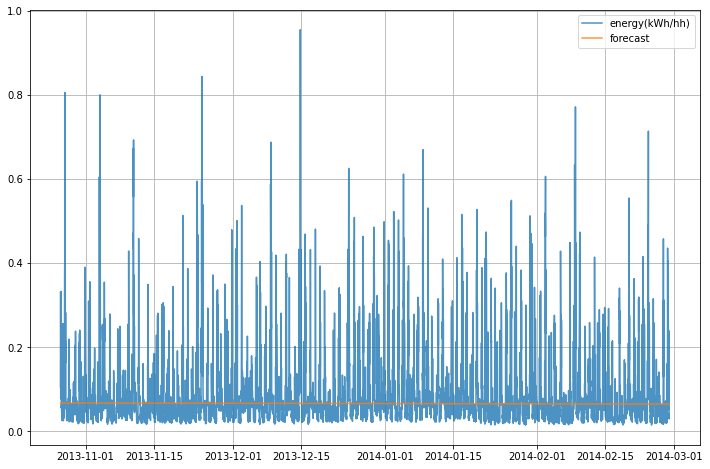

In [9]:
yhat = deep_learner.predictions()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_183170/3442304932.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


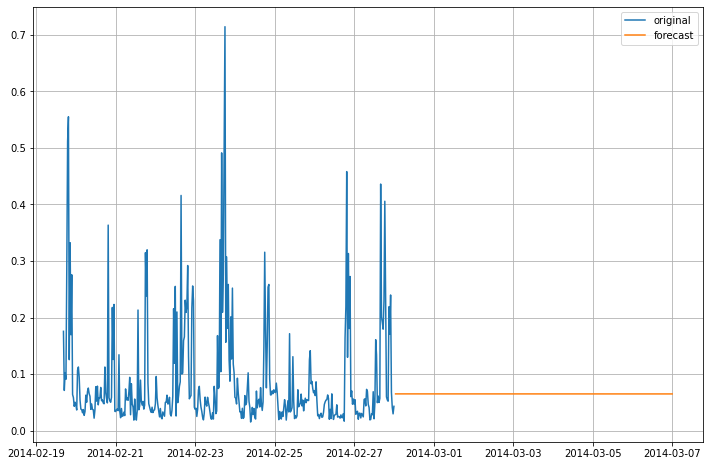

In [10]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [11]:
deep_learner.eval.MSE()

0.008824886003754915

In [12]:
deep_learner.eval.RMSE()

0.09394086439752891

In [13]:
deep_learner.eval.MAE()

0.05049792394601209

In [14]:
deep_learner.eval.MAPE()

64.34591496742794

In [15]:
peaks, peak_indexes, res = deep_learner.eval.peak_daily_consumption()
res

5951


80.61654696924737

In [16]:
deep_learner.predictions()

array([0.06776569, 0.06776522, 0.06776475, ..., 0.06497274, 0.06497227,
       0.0649718 ])

In [17]:
c = hh.tail(len(yhat)).copy()
c

,tstp,energy(kWh/hh)
396384,2014-02-24 12:30:00,0.020525
396385,2014-02-24 13:00:00,0.069935
396386,2014-02-24 13:30:00,0.040289
396387,2014-02-24 14:00:00,0.052452
396388,2014-02-24 14:30:00,0.055492
...,...,...
396547,2014-02-27 22:00:00,0.239833
396548,2014-02-27 22:30:00,0.067655
396549,2014-02-27 23:00:00,0.041049
396550,2014-02-27 23:30:00,0.029647


In [18]:
#train for all houses
lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
for lclid in lclid_list:
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    hh = hh.set_index("tstp")
    hh = hh.resample("H").sum()
    hh = hh.reset_index()

    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    
    deep_learner = Lin_reg_baseline(
        data = hh,
        Y_var = 'energy(kWh/hh)',
        train_test_split = 0.15,
        mode = "auto",
        lag = 24
    )
    deep_learner.model_init()
    
    mse.append(deep_learner.eval.MSE())
    rmse.append(deep_learner.eval.RMSE())
    mae.append(deep_learner.eval.MAE())
    mape.append(deep_learner.eval.MAPE())
houses = pd.Series(data=lclid_list,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")

res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape


154


In [19]:
res_df

,lclid,mse,rmse,mae,mape
0,MAC000150,0.005281,0.072673,0.043299,47.674782
1,MAC000152,0.007412,0.086091,0.048983,88.439458
2,MAC000153,0.007240,0.085090,0.059711,45.591959
3,MAC000159,0.003969,0.062997,0.041598,40.461969
4,MAC000165,0.007067,0.084067,0.050465,25.828244
5,MAC000168,0.004921,0.070147,0.033999,137.136518
6,MAC000169,0.004366,0.066077,0.038457,47.966996
7,MAC000173,0.009003,0.094885,0.060969,42.932554
8,MAC000179,0.004075,0.063838,0.037331,49.262095
9,MAC000181,0.003077,0.055471,0.029537,43.274422
